# Classification de base : classer les images de vêtements

 Ce guide forme un modèle de réseau neuronal pour classer des images de vêtements, comme des baskets et des chemises. Ce n'est pas grave si vous ne comprenez pas tous les détails ; il s'agit d'un aperçu rapide d'un programme TensorFlow complet avec les détails expliqués au fur et à mesure.

Ce guide utilise [tf.keras](https://www.tensorflow.org/guide/keras), une API de haut niveau pour créer et entraîner des modèles dans TensorFlow.

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.0-rc0


## Importer le jeu de données Fashion MNIST

Ce guide utilise le jeu de données [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) qui contient 70 000 images en niveaux de gris dans 10 catégories. Les images montrent des vêtements individuels en basse résolution (28 par 28 pixels).

Ici, 60 000 images sont utilisées pour former le réseau et 10 000 images pour évaluer avec quelle précision le réseau a appris à classer les images.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Le chargement de l'ensemble de données renvoie quatre tableaux NumPy :

* Les tableaux `train_images` et `train_labels` ont l'*ensemble d'apprentissage* — les données que le modèle utilise pour apprendre.
* Le modèle est testé contre l'*ensemble de test*, les `test_images`, et `test_labels` tableaux.

Chaque image est mappée sur une seule étiquette. Étant donné que les noms de classe ne sont pas inclus dans l'ensemble de données, stockez-les ici pour les utiliser ultérieurement lors du traçage des images :

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explorer les données

Ce qui suit montre qu'il y a 60 000 images dans l'ensemble d'apprentissage, chaque image étant représentée en 28 x 28 pixels :

In [4]:
train_images.shape

(60000, 28, 28)

De même, il y a 60 000 étiquettes dans l'ensemble d'apprentissage :

In [5]:
len(train_labels)

60000

Chaque étiquette est un entier compris entre 0 et 9 :

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Il y a 10 000 images dans l'ensemble de test. Encore une fois, chaque image est représentée en 28 x 28 pixels :

In [7]:
test_images.shape

(10000, 28, 28)

Et l'ensemble de test contient 10 000 étiquettes d'images :

In [8]:
len(test_labels)

10000

## Prétraiter les données

Les données doivent être prétraitées avant d'entraîner le réseau. Si vous inspectez la première image de l'ensemble d'apprentissage, vous verrez que les valeurs de pixels sont comprises entre 0 et 255 :

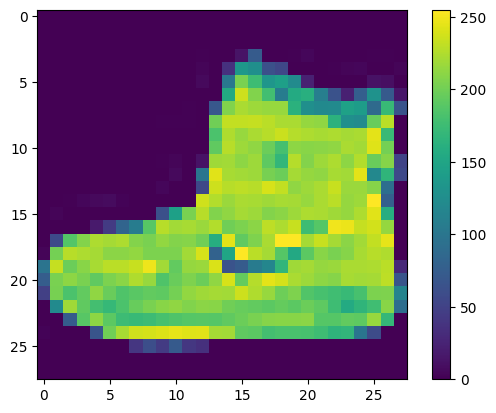

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Mettez ces valeurs à l'échelle sur une plage de 0 à 1 avant de les transmettre au modèle de réseau de neurones. Pour ce faire, divisez les valeurs par 255. Il est important que l' ensemble d'apprentissage et l' ensemble de test soient prétraités de la même manière :

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Pour vérifier que les données sont au format correct et que vous êtes prêt à créer et à entraîner le réseau, affichons les 25 premières images.

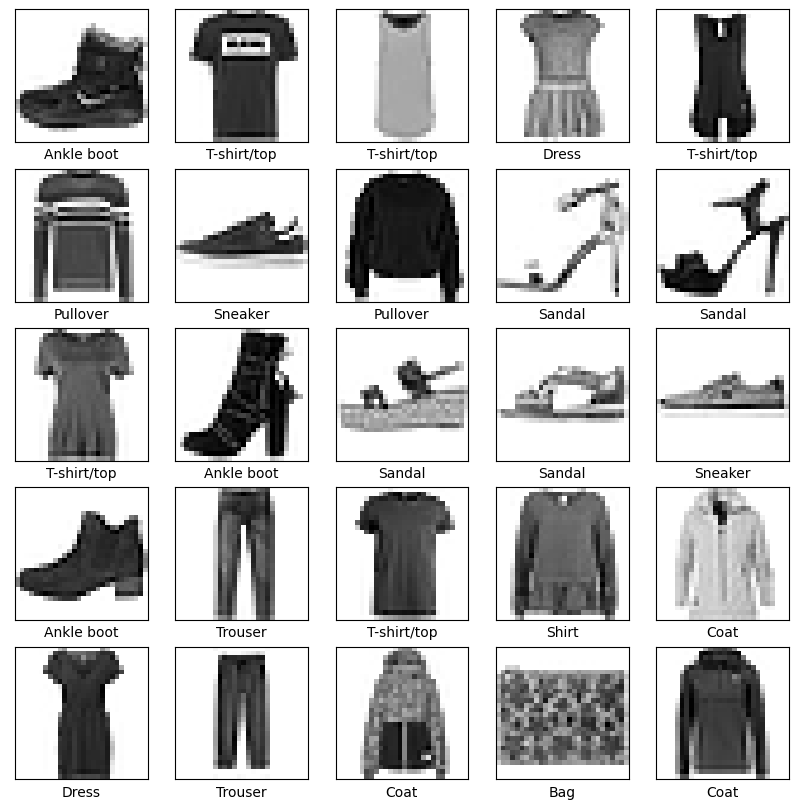

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Construire le modèle

La construction du réseau de neurones nécessite de configurer les couches du modèle, puis de compiler le modèle.

### Mettre en place les calques

Le bloc de construction de base d'un réseau de neurones est la [*couche*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Les couches extraient des représentations à partir des données qui y sont introduites. Espérons que ces représentations soient significatives pour le problème en question.

La plupart du deep learning consiste à enchaîner des couches simples. La plupart des couches, telles que `tf.keras.layers.Dense`, ont des paramètres qui sont appris pendant l'entraînement.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

La première couche de ce réseau, `tf.keras.layers.Flatten`, transforme le format des images d'un tableau bidimensionnel (de 28 par 28 pixels) en un tableau unidimensionnel (de 28 * 28 = 784 pixels). Considérez ce calque comme un dépilage de rangées de pixels dans l'image et leur alignement. Cette couche n'a pas de paramètres à apprendre ; il reformate seulement les données.

Une fois les pixels aplatis, le réseau se compose d'une séquence de deux couches  `tf.keras.layers.Dense` Ce sont des couches neuronales densément connectées ou entièrement connectées. La première couche Dense a 128 nœuds (ou neurones). La deuxième (et dernière) couche renvoie un tableau logits d'une longueur de 10. Chaque nœud contient un score qui indique que l'image actuelle appartient à l'une des 10 classes.

### Compiler le modèle

Avant que le modèle ne soit prêt pour l'entraînement, il a besoin de quelques réglages supplémentaires. Ceux-ci sont ajoutés lors de l'étape de [*compilation*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) du modèle :

* [*Fonction de perte*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) — mesure la précision du modèle pendant l'entraînement. Vous voulez minimiser cette fonction pour "orienter" le modèle dans la bonne direction.
* [*Optimiseur*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) — c'est ainsi que le modèle est mis à jour en fonction des données qu'il voit et de sa fonction de perte.
* [*Métriques*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) — utilisées pour surveiller les étapes de formation et de test. L'exemple suivant utilise precision , la fraction des images qui sont correctement classées.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Former le modèle

La formation du modèle de réseau de neurones nécessite les étapes suivantes :

1. Fournissez les données d'entraînement au modèle. Dans cet exemple, les données d'apprentissage se `train_images` et `train_labels` tableaux.
2. Le modèle apprend à associer des images et des étiquettes.
3. Vous demandez au modèle de faire des prédictions sur un ensemble de tests, dans cet exemple, le tableau `test_images`.
4. Vérifiez que les prédictions correspondent aux étiquettes du tableau `test_labels`.


### Nourrir le modèle

Pour commencer l'entraînement, appelez la méthode [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) ainsi appelée parce qu'elle « ajuste » le modèle aux données d'entraînement :

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1875/1875 [==============================] - 1s 362us/step - loss: 0.6259 - accuracy: 0.7832

Au fur et à mesure que le modèle s'entraîne, les mesures de perte et de précision sont affichées. Ce modèle atteint une précision d'environ 0,91 (ou 91 %) sur les données d'entraînement.

### Évaluer la précision

Ensuite, comparez les performances du modèle sur l'ensemble de données de test :

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
313/313 - 0s - loss: 0.3333 - accuracy: 0.8843

Test accuracy: 0.8842999935150146


### Faire des prédictions

Avec le modèle formé, vous pouvez l'utiliser pour faire des prédictions sur certaines images.
Les sorties linéaires du modèle, [logits](https://developers.google.com/machine-learning/glossary#logits). Attachez une couche softmax pour convertir les logits en probabilités, qui sont plus faciles à interpréter.

In [16]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [17]:
predictions = probability_model.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Ici, le modèle a prédit l'étiquette pour chaque image dans l'ensemble de test. Jetons un coup d'œil à la première prédiction :

In [18]:
predictions[0]

array([3.1253484e-07, 4.0030251e-08, 2.3347950e-06, 1.4625333e-09,
       3.2644489e-06, 1.0954810e-03, 3.1221502e-06, 4.4184461e-02,
       1.0202755e-08, 9.5471096e-01], dtype=float32)

Une prédiction est un tableau de 10 nombres. Ils représentent la "confiance" du modèle que l'image correspond à chacun des 10 articles vestimentaires différents. Vous pouvez voir quelle étiquette a la valeur de confiance la plus élevée :

In [19]:
np.argmax(predictions[0])

9

Ainsi, le modèle est le plus confiant que cette image est une bottine, ou `class_names[9]`.
L'examen de l'étiquette d'essai montre que cette classification est correcte :

In [20]:
test_labels[0]

9

Représentez graphiquement l'ensemble des 10 prédictions de classe.

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Vérifier les prédictions

Avec le modèle formé, vous pouvez l'utiliser pour faire des prédictions sur certaines images.

Regardons la 0e image, les prédictions et le tableau de prédiction. Les étiquettes de prédiction correctes sont bleues et les étiquettes de prédiction incorrectes sont rouges. Le nombre donne le pourcentage (sur 100) pour l'étiquette prédite.

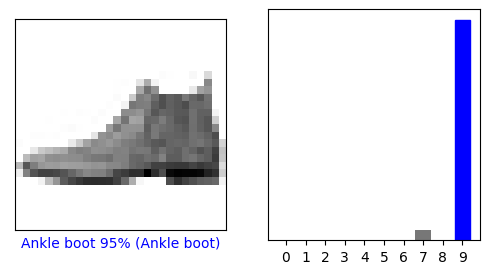

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

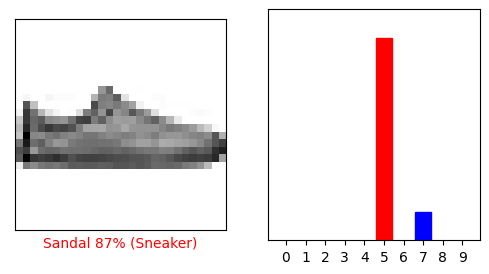

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Traçons plusieurs images avec leurs prédictions. Notez que le modèle peut se tromper même lorsqu'il est très confiant.

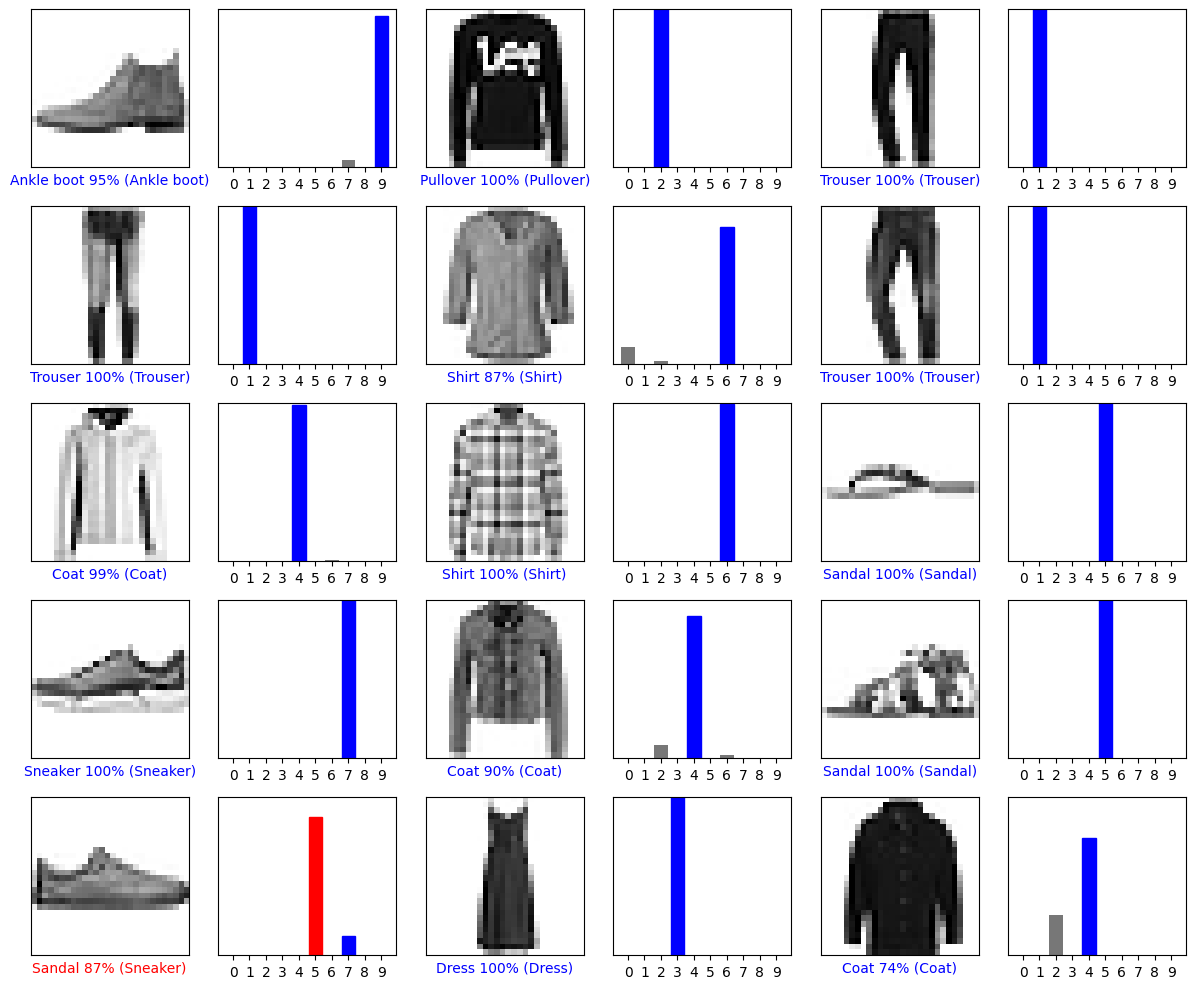

In [24]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Utiliser le modèle entraîné

Enfin, utilisez le modèle entraîné pour faire une prédiction sur une seule image.

In [25]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` modèles sont optimisés pour faire des prédictions sur un lot ou une collection d'exemples à la fois. Par conséquent, même si vous utilisez une seule image, vous devez l'ajouter à une liste :

In [26]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Prédisez maintenant l'étiquette correcte pour cette image :

In [27]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[4.3925011e-06 1.2383997e-13 9.9887115e-01 3.9718834e-10 5.9707946e-04
  4.4978667e-16 5.2734750e-04 1.4121589e-14 4.6058813e-11 1.5157478e-14]]


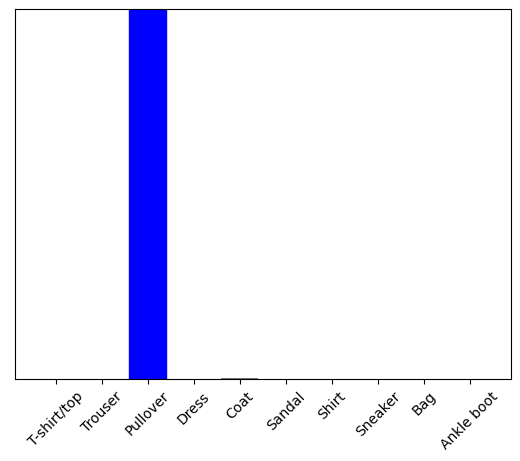

In [28]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` renvoie une liste de listes—une liste pour chaque image dans le lot de données. Saisissez les prédictions pour notre (seule) image dans le lot :

In [29]:
np.argmax(predictions_single[0])

2

Et le modèle prédit une étiquette comme prévu.